# BigContest Clustering

# 1. Setting Environment

## 1.1 Load libraries

In [2]:
library(data.table) # Data load
library(dplyr) # Preprocessing
library(tidyr) # preprocessing
library(ggplot2) # Visualization

## 1.2 Load data

In [3]:
activity <- fread("data/train_activity_new.csv", stringsAsFactors = F)
guild    <- fread("data/train_guild_new.csv", stringsAsFactors = F)
label    <- fread("data/train_label.csv", stringsAsFactors = F) %>%
  mutate(label = factor(label, levels = c("retained", "2month", "month", "week")))
payment  <- fread("data/train_payment_new.csv", stringsAsFactors = F)
trade    <- fread("data/train_trade_new.csv", stringsAsFactors = F)

Read 440323 rows and 39 (of 39) columns from 0.305 GB file in 00:00:14
Read 800000 rows and 4 (of 4) columns from 0.071 GB file in 00:00:03
Read 10414351 rows and 8 (of 8) columns from 1.743 GB file in 00:01:14


## 1.4 

In [83]:
draw_heatmap <- function(df, title) {
    p <- df %>% 
          gather(key = "variable", value = "value", -cluster) %>%
          ggplot(aes(cluster, variable, fill = value)) + 
          geom_tile() + geom_text(aes(label = round(value, 2))) +
          scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
          labs(title = title) +
          theme(plot.title = element_text(hjust = 0.5)) +
          scale_x_continuous(breaks = 1:6)
    
    return(p)
}

## 1.3 ETC Setting

In [4]:
theme_set(theme_minimal())
options(repr.plot.width = 10, repr.plot.height = 7)

# 2. Preprocessing

## 2.1 Transform trade

In [5]:
trade_new <- trade %>%
  gather(key = "role", value = "acc_id", source_acc_id, target_acc_id) %>%
  mutate(role = ifelse(role == "source_acc_id", "sell", "buy"),
         item_amount_new = (item_amount - min(item_amount))/(max(item_amount) - min(item_amount)))

In [6]:
trade_num <- trade_new %>% group_by(acc_id, role, item_type) %>%
  summarize(n_obs = n()) %>% ungroup() %>%
  mutate(type = paste0(role, "_", item_type)) %>%
  select(-role, -item_type) %>%
  spread(key = type, value = n_obs)
trade_num[is.na(trade_num)] <- 0
head(trade_num)

acc_id,buy_accessory,buy_costume,buy_gem,buy_grocery,buy_money,buy_weapon,sell_accessory,sell_costume,sell_gem,sell_grocery,sell_money,sell_weapon
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0,0,0,12,0,0,0,0,0,12,12,0
0000548b3eecb5e8c6736f9408ddd58f49d0a553b6f1f835f198957ee63e49e4,0,0,0,0,0,0,0,0,0,2,2,0
00006916672106f94f68d18e4a0532b53a40f4549d3a62f0cbf677dd25803668,0,0,0,3,0,0,0,0,0,3,3,0
0000d57170ee9d25dfa6cc8c7fbe88d2ffb561637020a4dec2791f1ee9a56b88,0,0,0,2,0,0,0,0,0,2,2,0
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0,0,0,0,0,0,0,0,0,0,2,0
00027152625b3c992d2e423b2d811d34c26a23eb3705d84dcde39cfb1b3bffd8,0,0,0,0,0,0,0,0,0,4,4,0


## 2.2 Transform payment

In [7]:
payment_sum <- payment %>% 
  mutate(payment_amount_new = (payment_amount - min(payment_amount))/(max(payment_amount) - min(payment_amount))) %>%
  group_by(acc_id) %>% summarize(sum_payment = sum(payment_amount))
head(payment_sum)

acc_id,sum_payment
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,-1.199188
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,-1.199188
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,-1.199188
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,-1.199188
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,-1.199188
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,-1.199188


In [8]:
payment_wk <- payment %>%
  select(-payment_id) %>%
  spread(key = "payment_week", value = "payment_amount")
names(payment_wk)[2:9] <- paste0("payment_wk", 1:8)
head(payment_wk)

acc_id,payment_wk1,payment_wk2,payment_wk3,payment_wk4,payment_wk5,payment_wk6,payment_wk7,payment_wk8
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985


## 2.3 Transform guild

In [9]:
guild_num <- label %>% 
  left_join(guild %>% group_by(acc_id) %>% summarize(guild_num = n()),
            by = "acc_id") %>%
  mutate(guild_num = ifelse(is.na(guild_num), 0, 1)) %>%
  select(-label)
head(guild_num)

acc_id,guild_num
b8fbf3f6a70e3f36843bffc70c18ff51a0d755a87616eca21b17b94d2ee2a734,0
ed500c4957956b3e99dc3985666850b582f812405eefb6ee731c3cf90f339b72,0
acc6afa23a6bf15e18151e4794c7789225ef9d682f473c243fd6d6b4b456e1ae,0
34095a3c9a2937ced3ea3fd75e22ce177dc5879d2a53f7d88842c604510a7ae5,0
26f3db6e8817a93c4ceda9a16f0832945e43d950b95882f0e5a54ab7ed01bebe,0
aaf2fb67be2d51bf75b973df5587dda57aa147c123c2a4307827f3b023ff0f96,0


## 2.4 Transform activity

### 2.4.1 Time

In [10]:
time <- activity %>% 
  mutate(play_time_new = (play_time - min(play_time))/(max(play_time) - min(play_time))) %>%
  group_by(acc_id) %>%
  summarize(wk_num = n(),
            acc_num = sum(cnt_dt),
            time_sum = sum(play_time_new)) %>%
  select(acc_id, wk_num, acc_num, time_sum)
head(time)

acc_id,wk_num,acc_num,time_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,2,12,1.434052579
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,8,25,0.001299603
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,5,12,0.003850860
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,6,31,0.158948413
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,2,3,0.002157738
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,8,39,0.234343585


### 2.4.2 EXP

In [11]:
exp <- activity %>%
  mutate(npc_exp_new = (npc_exp - min(npc_exp))/(max(npc_exp) - min(npc_exp)),
         npc_hongmun_new = (npc_hongmun - min(npc_hongmun))/(max(npc_hongmun) - min(npc_hongmun)),
         quest_exp_new = (quest_exp - min(quest_exp))/(max(quest_exp) - min(quest_exp)),
         quest_hongmun_new = (quest_hongmun - min(quest_hongmun))/(max(quest_hongmun) - min(quest_hongmun)),
         item_hongmun_new = (item_hongmun - min(item_hongmun))/(max(item_hongmun) - min(item_hongmun))) %>%
  group_by(acc_id) %>%
  summarize(npc_exp_sum = sum(npc_exp_new),
            npc_hongmun_sum = sum(npc_hongmun_new),
            quest_exp_sum = sum(quest_exp_new),
            quest_hongmun_sum = sum(quest_hongmun_new),
            item_hongmun_sum = sum(item_hongmun_new)) %>%
  select(acc_id, npc_exp_sum, quest_exp_sum, npc_hongmun_sum, quest_hongmun_sum, item_hongmun_sum)
head(exp)

acc_id,npc_exp_sum,quest_exp_sum,npc_hongmun_sum,quest_hongmun_sum,item_hongmun_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0.3809793534,1.3083729123,0.0007753815,0.225648815,0.0000000000
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0.0000000000,0.0000000000,0.0000000000,0.000000000,0.0000000000
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0.0000259147,0.0004109844,0.0000000000,0.000000000,0.0000000000
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0.0090312716,0.1235712206,0.0002182794,0.041978847,0.0002675048
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0.0000259147,0.0004109844,0.0000000000,0.000000000,0.0000000000
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0.0000000000,0.0000000000,0.0019382450,0.005506965,0.0027419247


### 2.4.3 Dungeon

In [12]:
dungeon_temp <- apply(activity[,c(17:30)], 2, function(x) { (x - min(x))/(max(x) - min(x)) }) %>% 
  as.data.frame() %>% cbind(activity[,c(2,3,4)]) %>% select(acc_id, wk, cnt_dt, everything())

dungeon <- dungeon_temp %>%
  mutate(enter_inzone = cnt_enter_inzone_solo + cnt_enter_inzone_normal,
         enter_skilled = cnt_enter_inzone_skilled,
         enter_raid = cnt_enter_raid + cnt_enter_raid_light,
         enter_bam = cnt_enter_bam,
         clear_inzone = cnt_clear_inzone_solo + cnt_clear_inzone_normal,
         clear_skilled = cnt_clear_inzone_skilled,
         clear_raid = cnt_clear_raid + cnt_clear_raid_light,
         clear_bam = cnt_clear_bam) %>%
  group_by(acc_id) %>%
  summarize(acc_num = sum(cnt_dt),
            enter_inzone_sum = sum(enter_inzone),
            enter_skilled_sum = sum(enter_skilled),
            enter_raid_sum = sum(enter_raid),
            enter_bam_sum = sum(enter_bam),
            clear_inzone_sum = sum(clear_inzone),
            clear_skilled_sum = sum(clear_skilled),
            clear_raid_sum = sum(clear_raid),
            clear_bam_sum = sum(clear_bam)) %>% 
  select(-acc_num) %>%
select(acc_id, enter_inzone_sum, enter_skilled_sum, enter_raid_sum, enter_bam_sum, 
       clear_inzone_sum, clear_skilled_sum, clear_raid_sum, clear_bam_sum)
head(dungeon)

acc_id,enter_inzone_sum,enter_skilled_sum,enter_raid_sum,enter_bam_sum,clear_inzone_sum,clear_skilled_sum,clear_raid_sum,clear_bam_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0.03225806,0,0,0,0.03898635,0,0,0
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0.00000000,0,0,0,0.00000000,0,0,0
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0.00000000,0,0,0,0.00000000,0,0,0
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0.17877183,0,0,0,0.17894392,0,0,0
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0.00000000,0,0,0,0.00000000,0,0,0
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0.28982361,0,0,0,0.29173639,0,0,0


### 2.4.4 Battle

In [13]:
battle_temp <- apply(activity %>% select(duel_cnt, duel_win, partybattle_cnt, partybattle_win), 2,
                    function(x) {(x - min(x))/(max(x) - min(x))}) %>% as.data.frame() %>%
 cbind(activity[,c(2,3,4)]) %>% select(acc_id, wk, cnt_dt, everything())

battle <- battle_temp %>% group_by(acc_id) %>%
  summarize(duel_cnt_sum = sum(duel_cnt),
            duel_win_sum = sum(duel_win),
            partybattle_cnt_sum = sum(partybattle_cnt),
            partybattle_win_sum = sum(partybattle_win))
head(battle)

acc_id,duel_cnt_sum,duel_win_sum,partybattle_cnt_sum,partybattle_win_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0,0,0,0
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0,0,0,0
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0,0,0,0
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0,0,0,0
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0,0,0,0
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0,0,0,0


### 2.4.5 chat

In [14]:
chat <- activity %>% select(acc_id, normal_chat, whisper_chat, district_chat, party_chat, guild_chat, faction_chat) %>%
  mutate(normal_chat_new = (normal_chat - min(normal_chat))/(max(normal_chat) - min(normal_chat)),
         whisper_chat_new = (whisper_chat - min(whisper_chat))/(max(whisper_chat) - min(whisper_chat)),
         district_chat_new = (district_chat - min(district_chat))/(max(district_chat) - min(district_chat)),
         party_chat_new = (party_chat - min(party_chat))/(max(party_chat) - min(party_chat)),
         guild_chat_new = (guild_chat - min(guild_chat))/(max(guild_chat) - min(guild_chat)),
         faction_chat_new = (faction_chat - min(faction_chat))/(max(faction_chat) - min(faction_chat))) %>%
  group_by(acc_id) %>%
  summarize(normal_chat_sum = sum(normal_chat_new),
            whisper_chat_sum = sum(whisper_chat_new),
            district_chat_sum = sum(district_chat_new),
            party_chat_sum = sum(party_chat_new),
            guild_chat_sum = sum(guild_chat_new),
            faction_chat_sum = sum(faction_chat_new)) 
head(chat)

acc_id,normal_chat_sum,whisper_chat_sum,district_chat_sum,party_chat_sum,guild_chat_sum,faction_chat_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0.000000e+00,0.000000000,0,0.0000000000,0,0
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0.000000e+00,0.000000000,0,0.0000000000,0,0
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0.000000e+00,0.000000000,0,0.0000000000,0,0
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,2.469837e-05,0.004710446,0,0.0005447895,0,0
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0.000000e+00,0.000000000,0,0.0000000000,0,0
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0.000000e+00,0.004710446,0,0.0000000000,0,0


### 2.4.6 ETC

In [21]:
etc <- activity %>% select(acc_id, cnt_use_buffitem, gathering_cnt, making_cnt, game_combat_time, get_money) %>%
  mutate(cnt_use_buffitem_new = (cnt_use_buffitem - min(cnt_use_buffitem))/(max(cnt_use_buffitem) - min(cnt_use_buffitem)),
         gathering_cnt_new = (gathering_cnt - min(gathering_cnt))/(max(gathering_cnt) - min(gathering_cnt)),
         making_cnt_new = (making_cnt - min(making_cnt))/(max(making_cnt) - min(making_cnt)),
         game_combat_time_new = (game_combat_time - min(game_combat_time))/(max(game_combat_time) - min(game_combat_time)),
         get_money_new = (get_money - min(get_money))/(max(get_money) - min(get_money))) %>%
  group_by(acc_id) %>%
  summarize(cnt_use_buffitem_sum = sum(cnt_use_buffitem_new),
            gathering_cnt_sum = sum(gathering_cnt_new),
            making_cnt_sum = sum(making_cnt_new),
            game_combat_time_sum = sum(game_combat_time_new),
            get_money_sum = sum(get_money_new))
head(etc)

acc_id,cnt_use_buffitem_sum,gathering_cnt_sum,making_cnt_sum,game_combat_time_sum,get_money_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0.3186154265,0,0,0.5465439427,1.186224e-06
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0.0000000000,0,0,0.0000000000,0.000000e+00
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0.0002725538,0,0,0.0003112564,0.000000e+00
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0.0223494140,0,0,0.0455323595,7.524995e-07
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0.0002725538,0,0,0.0002890238,0.000000e+00
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0.1117470700,0,0,0.1632539630,1.201576e-06


# 3. Data integration

In [25]:
game <- label %>% 
  left_join(trade_num, by = "acc_id") %>%
  left_join(payment_sum, by = "acc_id") %>% 
  left_join(payment_wk, by = "acc_id") %>% 
  left_join(guild_num, by = "acc_id") %>% 
  left_join(time, by = "acc_id") %>% 
  left_join(exp, by = "acc_id") %>% 
  left_join(dungeon, by = "acc_id") %>% 
  left_join(battle, by = "acc_id") %>% 
  left_join(chat, by = "acc_id") %>% 
  left_join(etc, by = "acc_id")
game[is.na(game)] <- 0

game_cluster <- apply(game[,3:55], 2, function(x) {scale(x)}) %>% data.frame()

# 4. Clustering

## 4.1 Search # of cluster ( = k )

### 4.1.1 Sum of Square

In [26]:
set.seed(7274)
K <- 1:10
clustList <- lapply(K, function(x, d) { kmeans(d, center = x) }, d = game_cluster)

ssB <- sapply(clustList, function(x) { getElement(x, "betweenss") })
ssW <- sapply(clustList, function(x) { getElement(x, "tot.withinss")})

Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 5000000)"

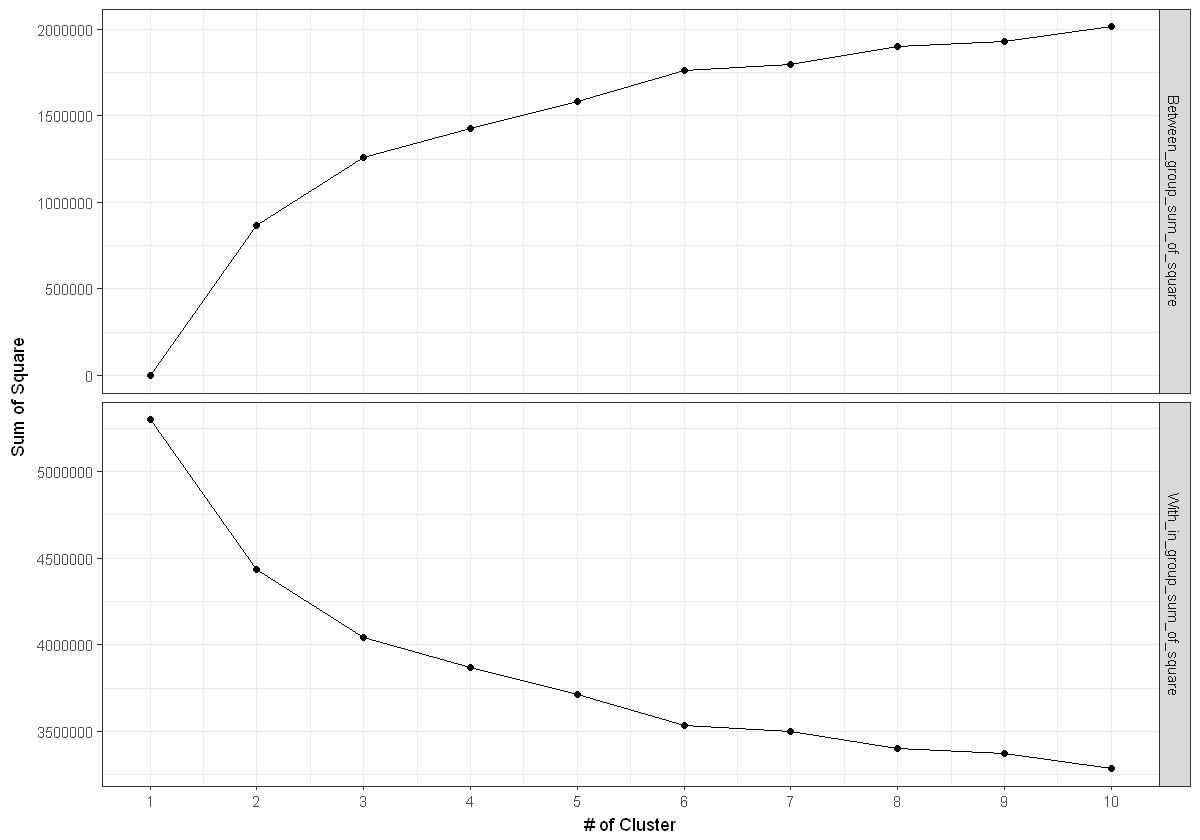

In [27]:
data.frame(k = K, Between_group_sum_of_square = ssB, With_in_group_sum_of_square = ssW) %>%
  gather(key = "type", value = "value", -k) %>%
  ggplot(aes(k, value)) + geom_point() + geom_line(group = 1) + 
  facet_grid(type ~ ., scales = "free") + 
  labs(x = "# of Cluster", y = "Sum of Square") + theme_bw() +
  scale_x_continuous(breaks = 1:10)

In [29]:
n <- dim(game_cluster)[1]
ch <- (ssB/(K-1))/(ssW/(n-K))

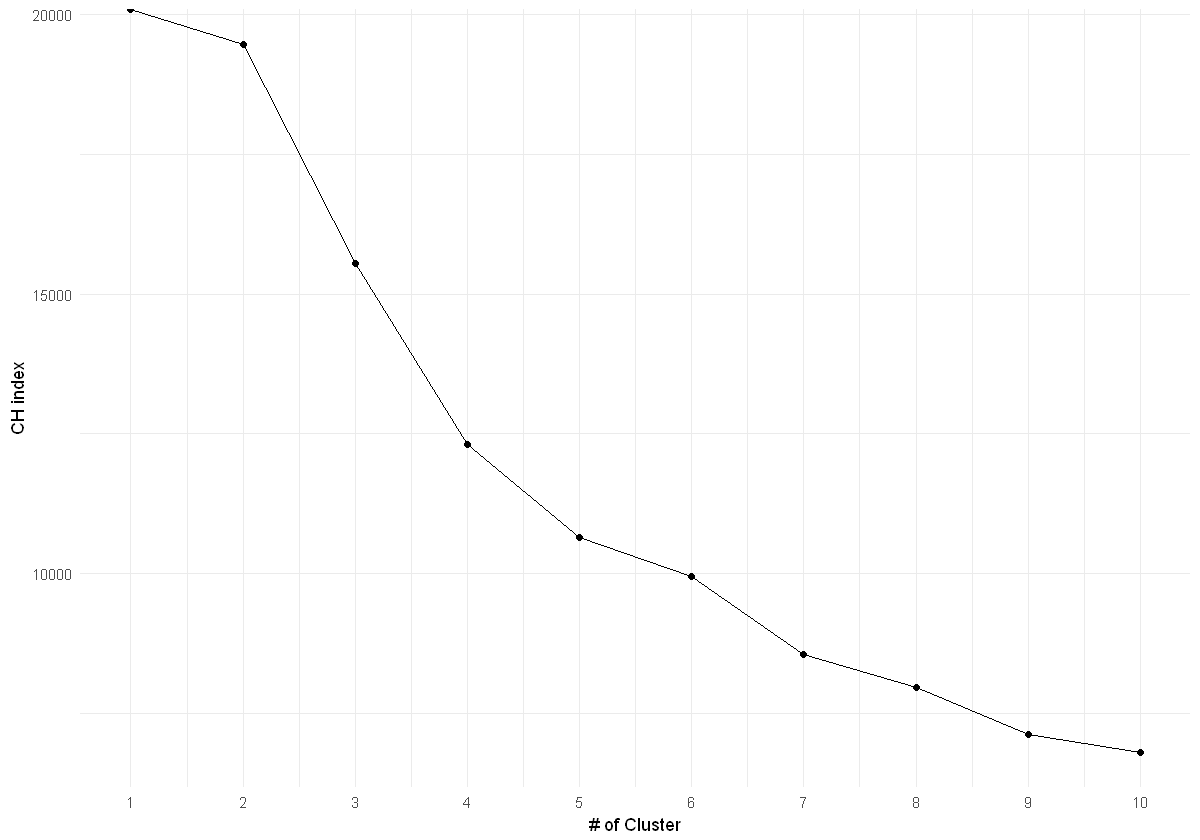

In [30]:
data.frame(k = K, index = ch) %>%
  ggplot(aes(k, index)) + geom_point() + geom_line() +
  labs(x = "# of Cluster", y = "CH index") +
  scale_x_continuous(breaks = 1:10)

## 4.2 Clustering with k

In [31]:
set.seed(9866)
k <- 6
kmeans_result <- kmeans(game_cluster, centers = k)

In [32]:
center_result <- kmeans_result$centers %>% data.frame()
center_result$cluster <- 1:k

### 4.2.1 Cluster 별 Label

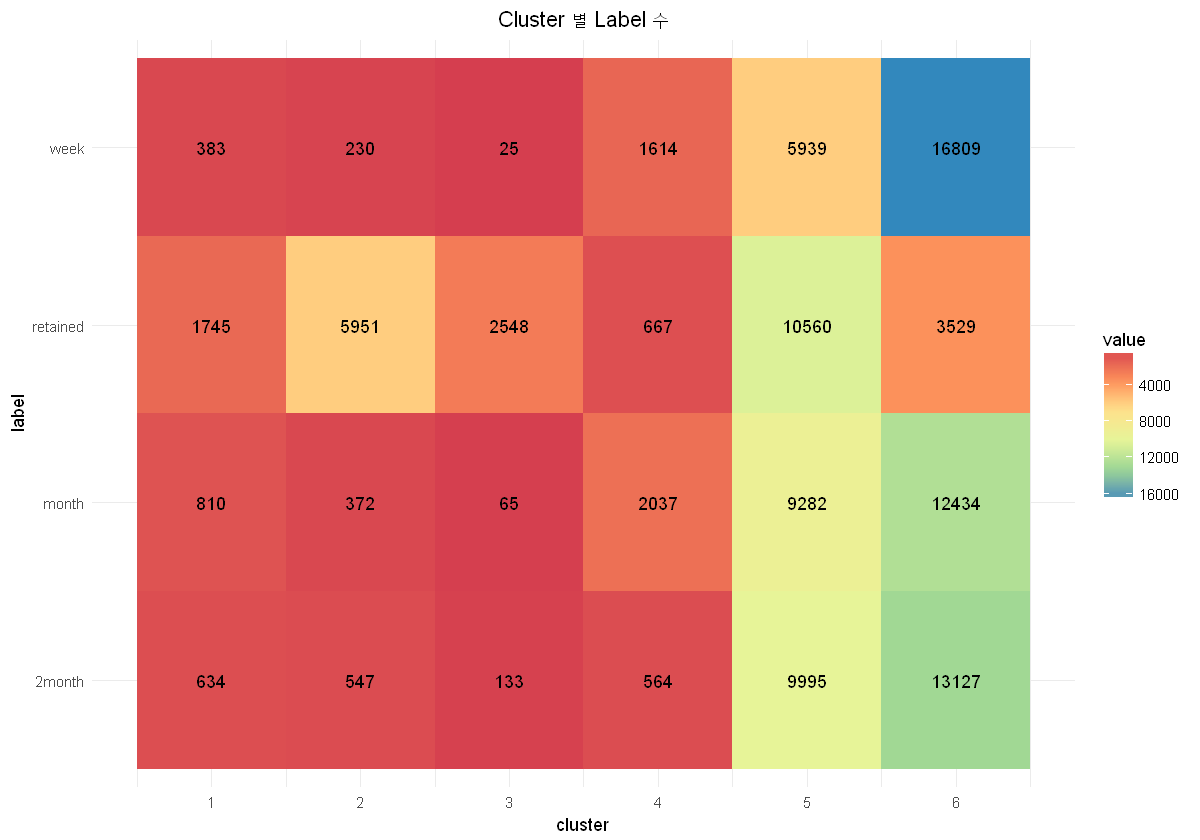

In [78]:
kmeans_df <- game %>% mutate(cluster = kmeans_result$cluster)
cluster_label <- kmeans_df %>% group_by(cluster, label) %>% summarize(n_obs = n()) %>%
  spread(key = "label", value = "n_obs")
cluster_label %>%
  gather(key = "label", value = "num", -cluster) %>%
  ggplot(aes(cluster, label, fill = num)) +
  geom_tile() + geom_text(aes(label = num)) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 Label 수") +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_continuous(breaks = 1:6)

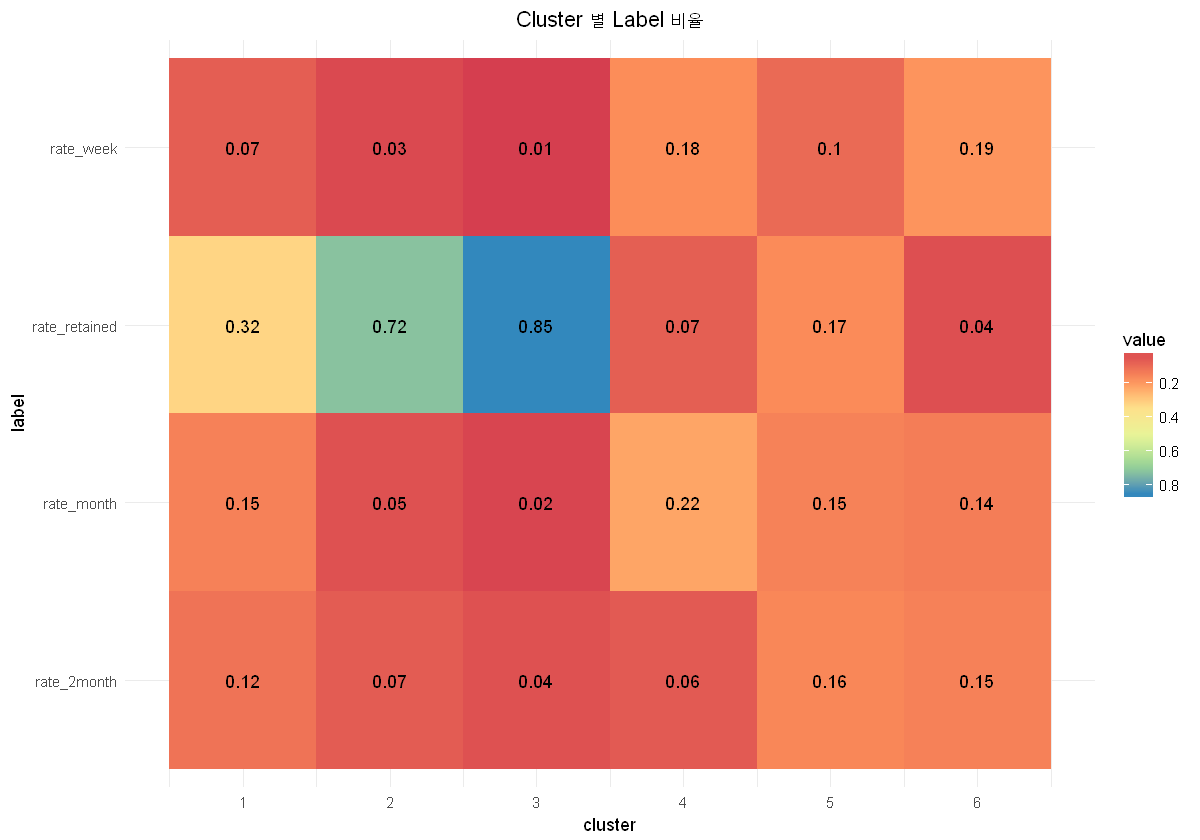

In [74]:
apply(cluster_label[2:5], 2, function(x) {x/rowSums(cluster_label[,-1])}) %>% 
  data.frame() %>% mutate(cluster = 1:k) %>%
  rename(rate_2month = X2month, 
         rate_month = month,
         rate_retained = retained,
         rate_week = week) %>%
  gather(key = "label", value = "num", -cluster) %>%
  ggplot(aes(cluster, label, fill = num)) +
  geom_tile() + geom_text(aes(label = round(num, 2))) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 Label 비율") + 
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_continuous(breaks = 1:6)

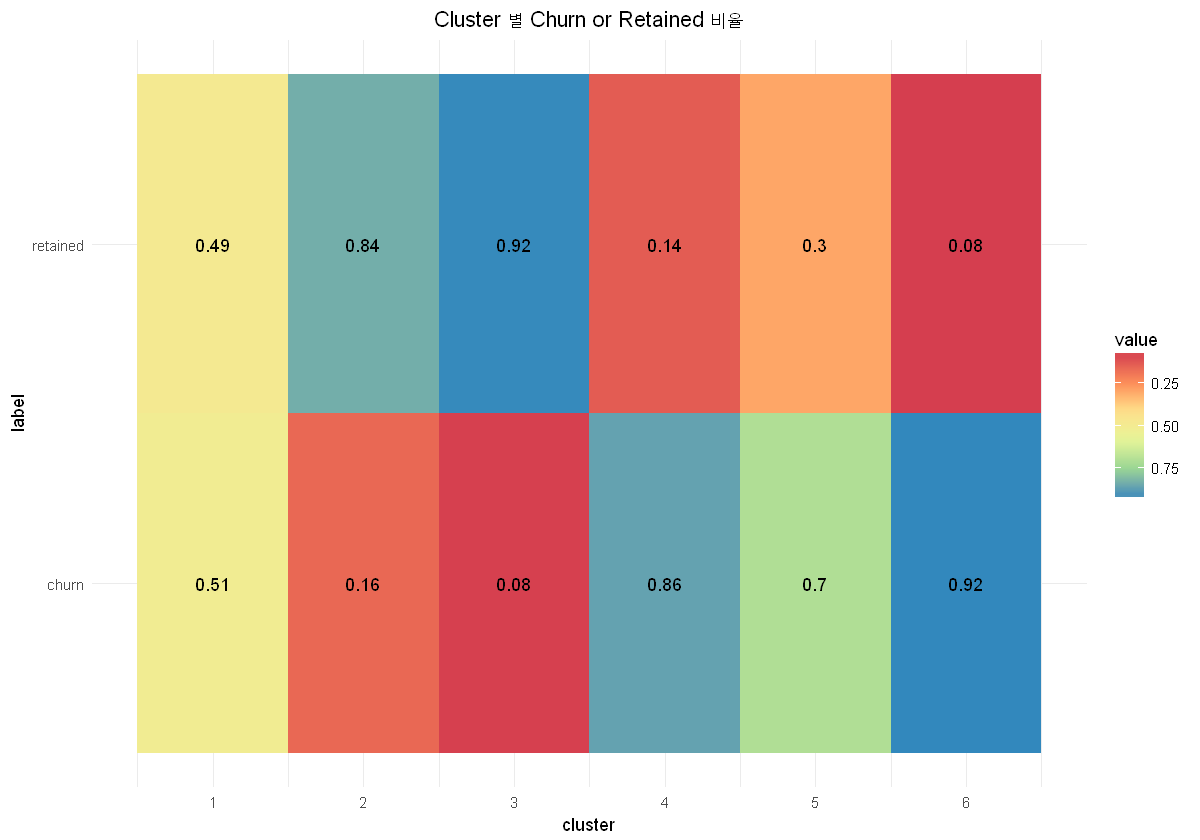

In [75]:
cluster_label$churn <- cluster_label[,c(3,4,5)] %>% rowSums() 
cluster_label_reduced <- cluster_label %>% select(cluster, retained, churn)
apply(cluster_label_reduced[,-1], 2, function(x) {x/rowSums(cluster_label_reduced[,-1])}) %>% 
  data.frame() %>% mutate(cluster = 1:k) %>%
  gather(key = "label", value = "rate", -cluster) %>%
  ggplot(aes(cluster, label, fill = rate)) +
  geom_tile() + geom_text(aes(label = round(rate, 2))) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 Churn or Retained 비율") + 
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_continuous(breaks = 1:6)

### 4.2.2 Cluster 별 변수

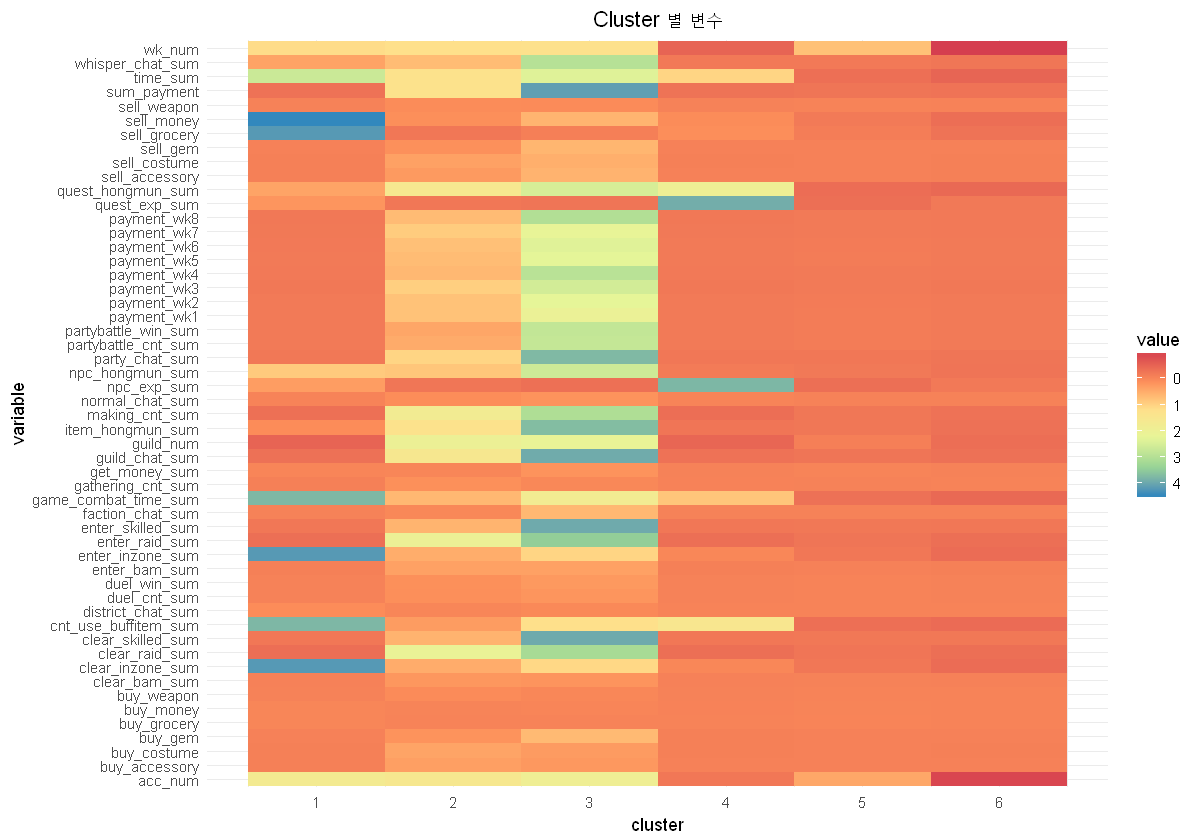

In [72]:
center_result %>% 
  gather(key = "variable", value = "value", -cluster) %>%
  ggplot(aes(cluster, variable, fill = value)) + 
  geom_tile() + 
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 변수") +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_continuous(breaks = 1:6)

#### 4.2.2.1 Cluster별 Trade 변수

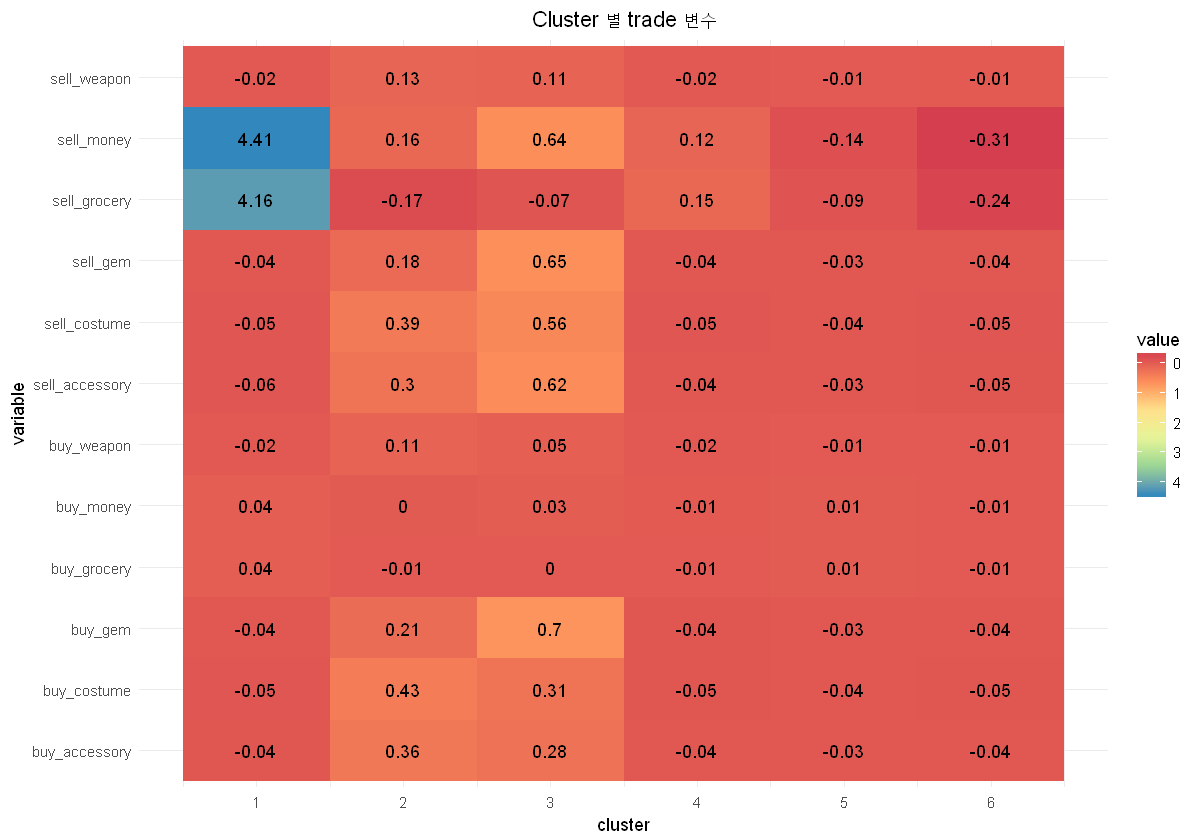

In [84]:
draw_heatmap(center_result[,c(1:12,54)], "Cluster 별 trade 변수")

#### 4.2.2.2 Cluster별 Payment 변수

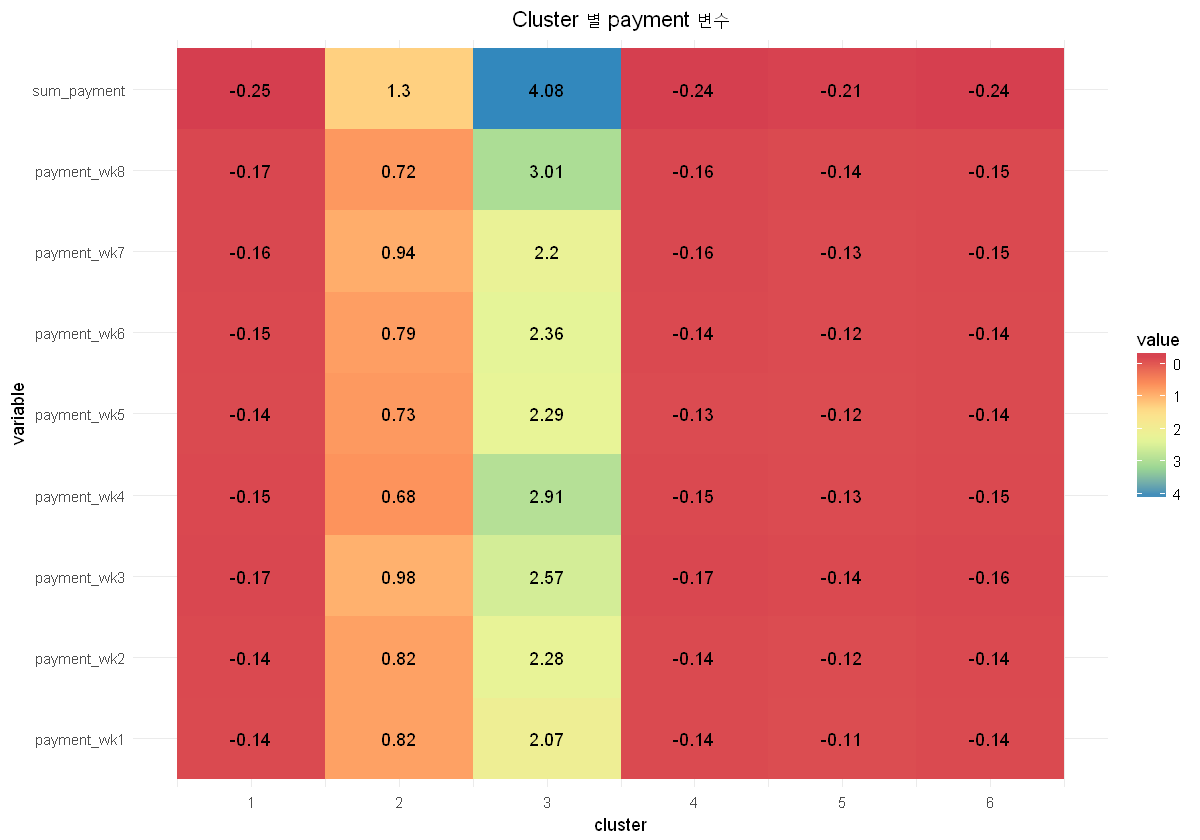

In [85]:
draw_heatmap(center_result[,c(13:21,54)], "Cluster 별 payment 변수")

#### 4.2.2.3 Cluster별 Guild & Time 변수

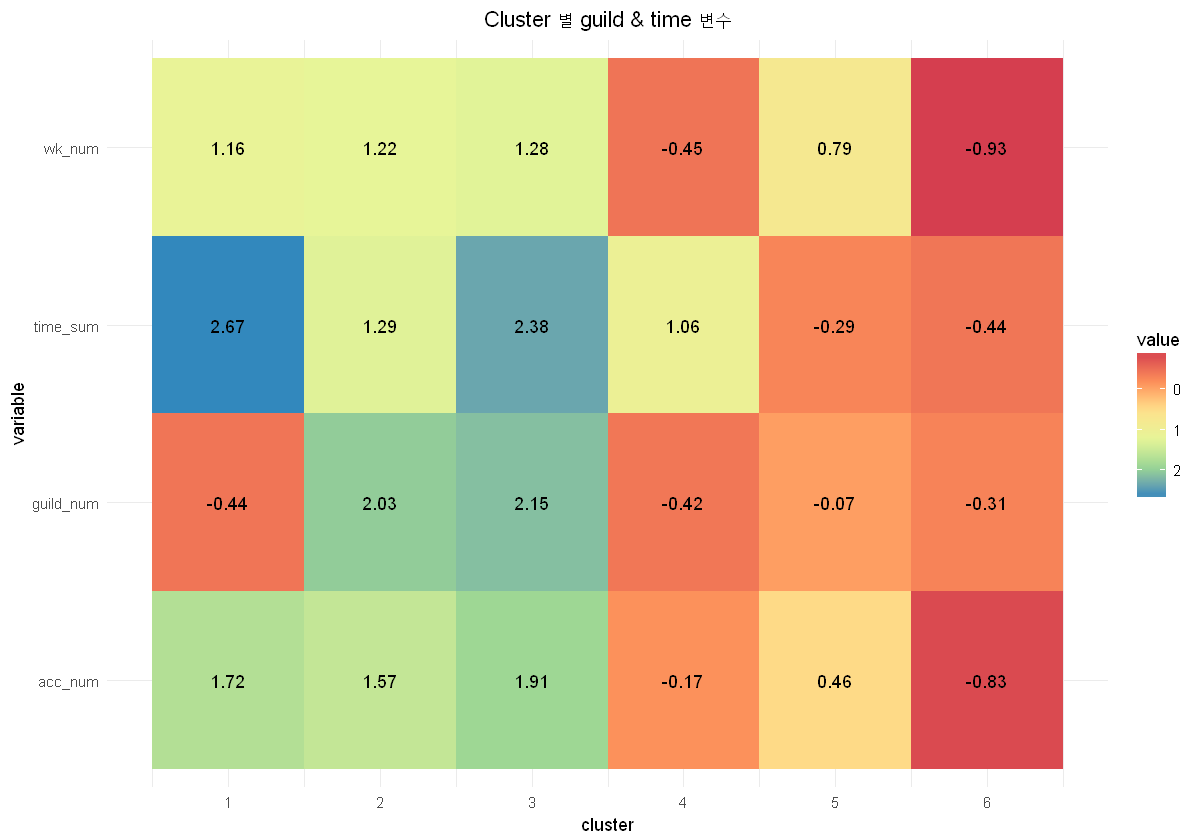

In [86]:
draw_heatmap(center_result[,c(22:25,54)], "Cluster 별 guild & time 변수")

#### 4.2.2.4 Cluster별 EXP 변수

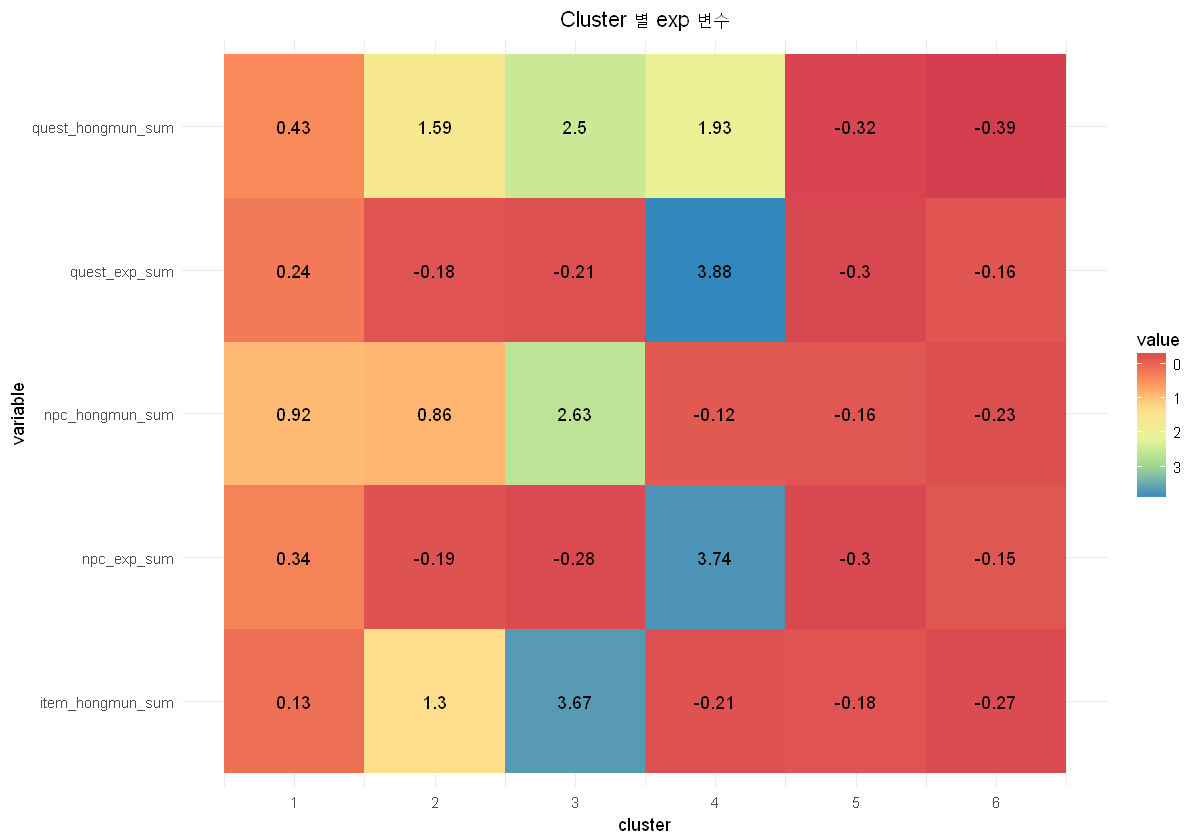

In [87]:
draw_heatmap(center_result[,c(26:30, 54)], "Cluster 별 exp 변수")

#### 4.2.2.5 Cluster별 Dungeon 변수

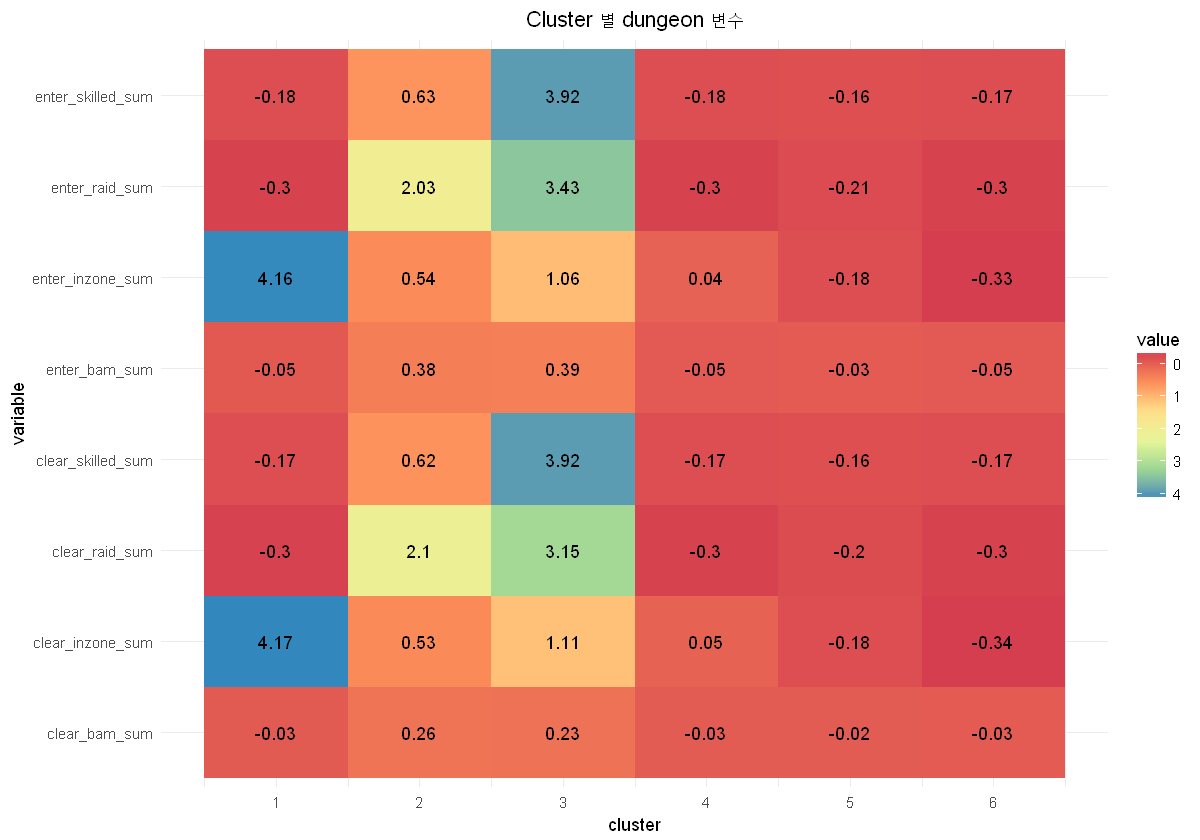

In [88]:
draw_heatmap(center_result[,c(31:38, 54)], "Cluster 별 dungeon 변수")

#### 4.2.2.6 Cluster별 Battle 변수

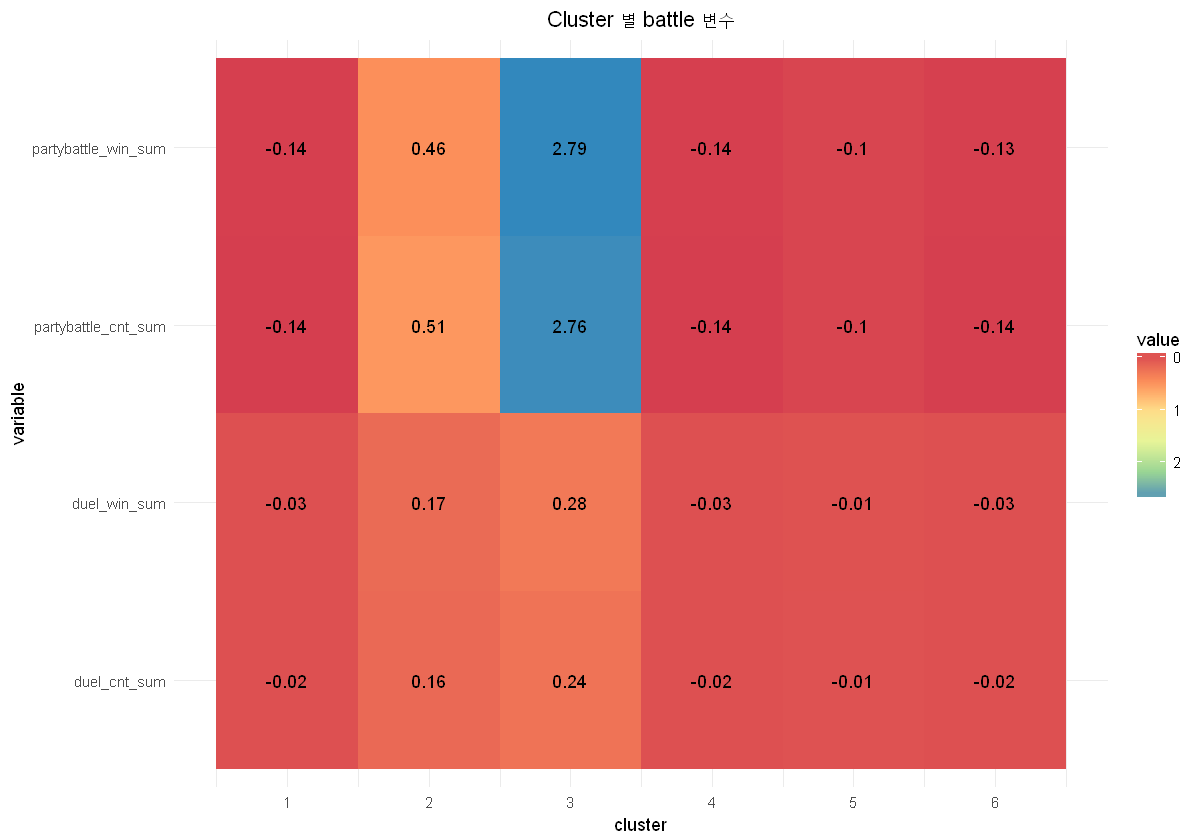

In [89]:
draw_heatmap(center_result[,c(39:42, 54)], "Cluster 별 battle 변수")

#### 4.2.2.7 Cluster별 Chat 변수

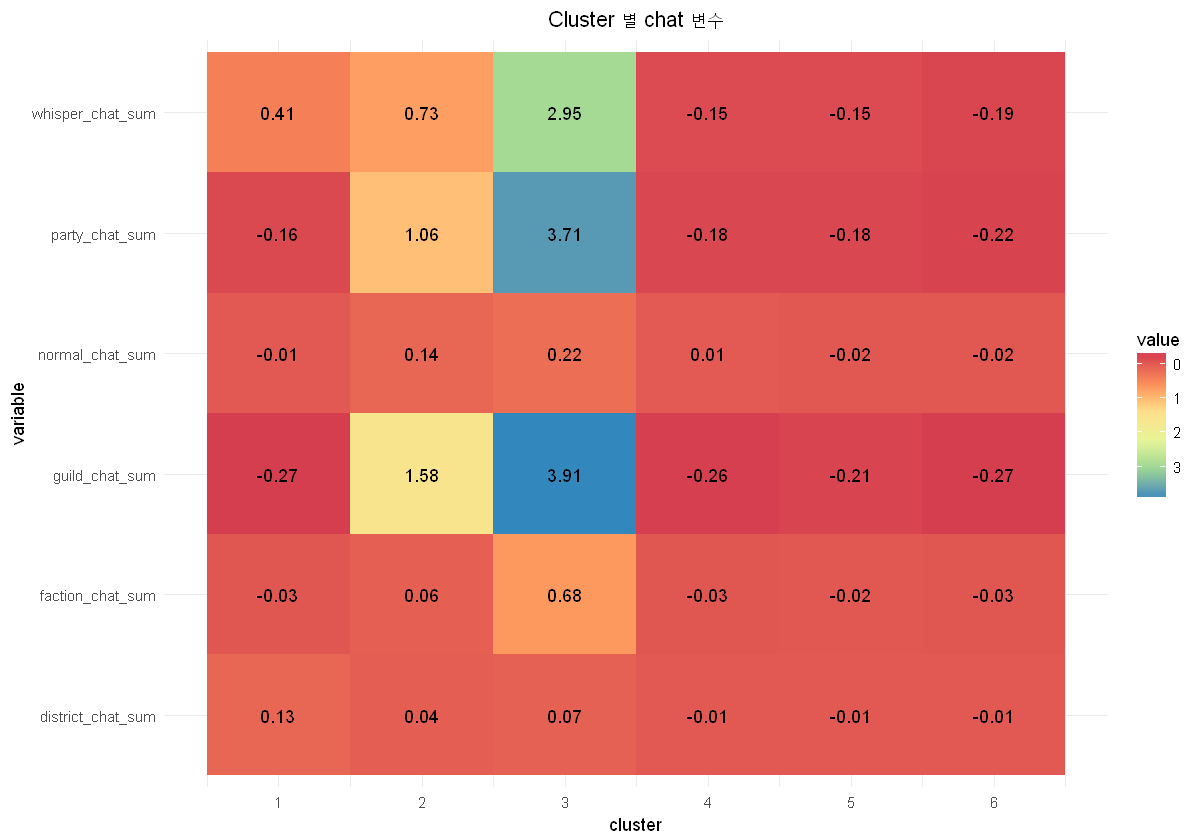

In [90]:
draw_heatmap(center_result[,c(43:48, 54)], "Cluster 별 chat 변수")

#### 4.2.2.8 Cluster별 ETC 변수

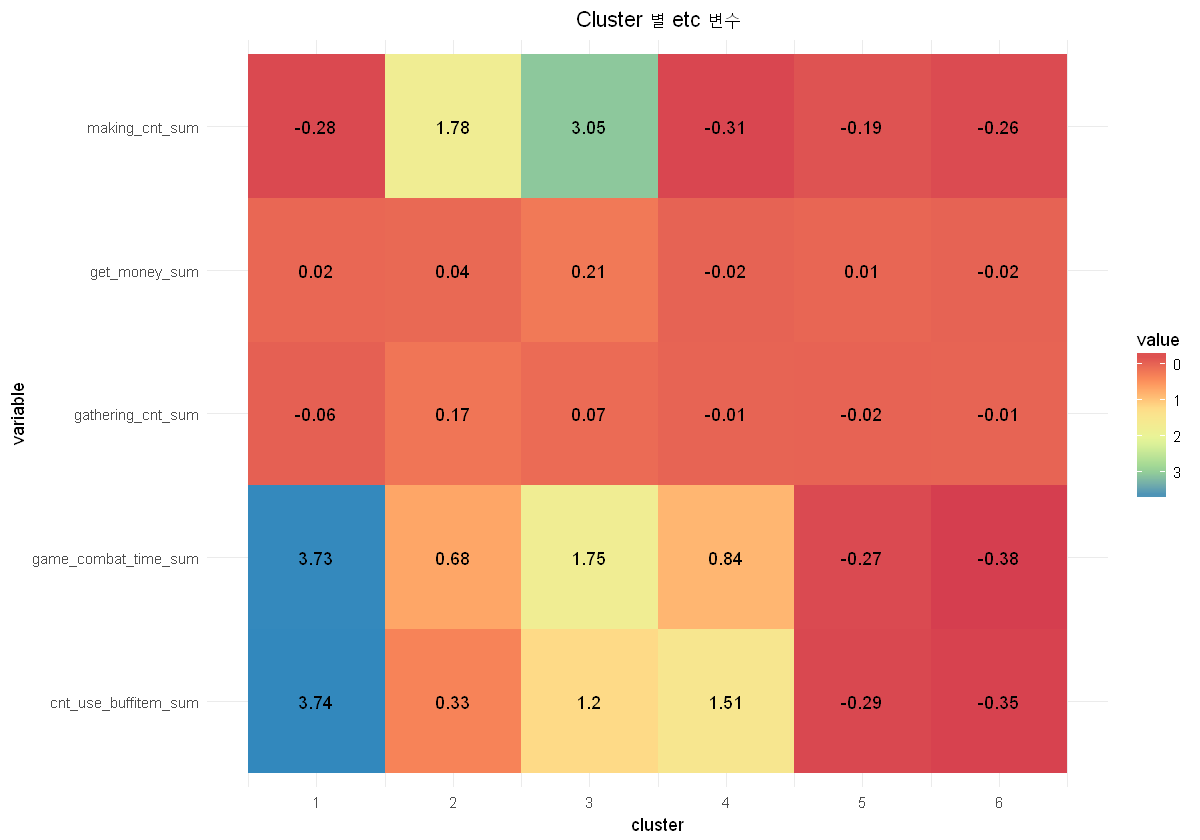

In [91]:
draw_heatmap(center_result[,c(49:54)], "Cluster 별 etc 변수")